<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/state_farm/state_farm_task-step_2-build_your_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State Farm Pre-employment Assessment
### *Model-based supervised learning binary classification task*
Your work will be evaluated in the following areas:
- The appropriateness of the steps you took
- The complexity of your models
- The performance of each model on the test set (using AUC)
- The organization and readability of your code
- The write-up comparing the models
---

## Step 2 - Build your models
For this exercise, you are required to build two models. The first model must be a logistic regression. The second model must be a decision tree, random forest, gradient boosted machine, support vector machine, or neural network. Even if multiple models were considered, please only submit two models for evaluation.’

We will begin by importing relevant libraries.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, QuantileTransformer, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import joblib
from google.colab import files

Next, we use the pandas library to load our CSV data.

In [2]:
train_data = pd.read_csv("exercise_40_train.csv")
test_data = pd.read_csv("exercise_40_test.csv")

In [3]:
train_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


### Prepare the data

Separate the predictors from the labels

In [21]:
train = train_data.drop("y", axis=1)
train_labels = train_data["y"].copy()

Drop unnecessary columns

In [22]:
train = train.drop(columns=["x39", "x99", "x79", "x28"])

Convert object columns to binary int64


In [23]:
binary_features = ["x24", "x31", "x93"]
for col in binary_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

Replace null values in `x33` and `x77` with most likely value based on probabilities

In [24]:
for col in ["x33", "x77"]:
    probs = train[col].value_counts(normalize=True)
    missing = train[col].isna()
    train.loc[missing, col] = np.random.choice(probs.index, size=len(train[missing]), p=probs.values)

Combine duplicate days in `x3`

In [25]:
day_mapping = {
    "Mon": "Monday",
    "Tue": "Tuesday",
    "Wed": "Wednesday",
    "Thur": "Thursday",
    "Fri": "Friday",
    "Sat": "Saturday",
    "Sun": "Sunday"
}
train["x3"] = train["x3"].replace(day_mapping)

Convert the `x7` column to a float by removing the % sign and dividing by 100. Convert the `x19` column to a float by removing the $ sign.

In [26]:
train['x7'] = train['x7'].str.strip('%').astype(float) / 100
train['x19'] = train['x19'].str.strip('$').astype(float)

### Create and run preprocessing pipeline

In [9]:
# Define transformers for each group of columns
one_hot_features = ["x33", "x77", "x3", "x60", "x65"]
range_based_features = ["x58", "x67", "x71", "x84"]
quantile_transform_features = ["x12", "x18", "x61", "x92", "x40", "x57"]
log_transform_features = ["x14", "x16", "x21", "x42", "x45", "x55", "x70", "x73", "x75", "x82", "x89", "x96"]

one_hot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder())
])

def custom_discretizer(X, low_quantile=0.25, high_quantile=0.75):
    low_bound = np.quantile(X, low_quantile, axis=0)
    high_bound = np.quantile(X, high_quantile, axis=0)
    return np.where(X < low_bound, 0, np.where(X <= high_bound, 1, 2))

range_based_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("custom_discretizer", FunctionTransformer(custom_discretizer, validate=True)),
    ("one_hot", OneHotEncoder())
])

quantile_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("quantile_transform", QuantileTransformer(output_distribution="normal"))
])

def log1p_with_positive_shift(X):
    positive_shift = np.abs(np.min(X, axis=0)) + 1e-6
    return np.log1p(X + positive_shift)

log_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(log1p_with_positive_shift, validate=True)),
    ("standard_scaler", StandardScaler())
])

remaining_float_features = list(set(train.select_dtypes(include=["float64"]).columns) - set(range_based_features) - set(quantile_transform_features) - set(log_transform_features))

float_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())
])

# Create ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("one_hot", one_hot_transformer, one_hot_features),
    ("range_based", range_based_transformer, range_based_features),
    ("quantile_transform", quantile_transformer, quantile_transform_features),
    ("log_transform", log_transformer, log_transform_features),
    ("float_transform", float_transformer, remaining_float_features)
])

# Apply the preprocessing pipeline
X_transformed = preprocessor.fit_transform(train)

# Get the column names from the transformers
one_hot_cols = preprocessor.named_transformers_["one_hot"].named_steps["one_hot"].get_feature_names_out(one_hot_features)
range_based_categories = ["low", "middle", "high"]
range_based_cols = [f"{col}_{cat}" for col in range_based_features for cat in range_based_categories]
quantile_transform_cols = [f"quantile_{col}" for col in quantile_transform_features]
log_transform_cols = [f"log_{col}" for col in log_transform_features]
float_transform_cols = [f"float_{col}" for col in remaining_float_features]

print("One-hot cols:", len(one_hot_cols))
print("Range-based cols:", len(range_based_cols))
print("Quantile transform cols:", len(quantile_transform_cols))
print("Log transform cols:", len(log_transform_cols))
print("Float transform cols:", len(float_transform_cols))

# Combine column names
columns = (list(one_hot_cols)
           + list(range_based_cols)
           + quantile_transform_cols
           + log_transform_cols
           + float_transform_cols)

print("Total expected columns:", len(columns))
print("Actual columns in transformed dataset:", X_transformed.shape[1])

train_transformed = pd.DataFrame(X_transformed, columns=columns)

One-hot cols: 82
Range-based cols: 12
Quantile transform cols: 6
Log transform cols: 12
Float transform cols: 64
Total expected columns: 176
Actual columns in transformed dataset: 176


In [92]:
train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 176 entries, x33_Alabama to float_x41
dtypes: float64(176)
memory usage: 53.7 MB


In [10]:
train_transformed.columns[train_transformed.isnull().sum() != 0]

Index([], dtype='object')

Split the processed training data into train & test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, train_labels, test_size=0.2, random_state=42)

Train a logistic regression model and output mean accuracy score.

In [12]:
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression.fit(X_train, y_train)

logreg_train_score = logistic_regression.score(X_train, y_train)
logreg_test_score = logistic_regression.score(X_test, y_test)

print(f"Logistic Regression train score: {logreg_train_score}")
print(f"Logistic Regression test score: {logreg_test_score}")

Logistic Regression train score: 0.8579375
Logistic Regression test score: 0.858375


Compare this accuracy with a logistic regression model trained on data pre-processed in a more naive fashion.

In [13]:
train = train_data.drop("y", axis=1) # restore training data

numeric_features = train.select_dtypes(include=["float64"]).columns
categorical_features = train.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

simpler_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_simpler_transformed = simpler_preprocessor.fit_transform(train)

X_train_simpler, X_test_simpler, y_train_simpler, y_test_simpler = train_test_split(X_simpler_transformed, train_labels, test_size=0.2, random_state=42)


In [14]:
logistic_regression_simpler = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_simpler.fit(X_train_simpler, y_train_simpler)

logreg_simpler_train_score = logistic_regression_simpler.score(X_train_simpler, y_train_simpler)
logreg_simpler_test_score = logistic_regression_simpler.score(X_test_simpler, y_test_simpler)

print(f"Simpler Logistic Regression train score: {logreg_simpler_train_score}")
print(f"Simpler Logistic Regression test score: {logreg_simpler_test_score}")


Simpler Logistic Regression train score: 0.8861875
Simpler Logistic Regression test score: 0.860125


The sophisticated preprocessing we did does not seem to matter when only looking at mean accuracy. Let's also see how a dummy classifier performs which just classifies every image as the most frequent class, which is 0. 

In [18]:
train_labels.value_counts()

0    29991
1     5110
Name: y, dtype: int64

In [15]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
print(any(dummy_clf.predict(X_train))) # prints False: no 1s detected

False


In [16]:
dummy_acc = cross_val_score(dummy_clf, X_train, y_train, cv=3, scoring="accuracy")
log_reg_acc = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
simpler_log_reg_acc = cross_val_score(logistic_regression_simpler, X_train_simpler, y_train_simpler, cv=3, scoring="accuracy")
print('Dummy classifier accuracy:', dummy_acc)
print('Logistic Regression classifier accuracy:', log_reg_acc)
print('Simpler Logistic Regression classifier accuracy:', simpler_log_reg_acc)

Dummy classifier accuracy: [0.85422331 0.85412956 0.85420964]
Logistic Regression classifier accuracy: [0.8544108  0.85703572 0.85908494]
Simpler Logistic Regression classifier accuracy: [0.85459829 0.85319209 0.85758485]


These models perform basically the same as the dummy classifier when looking only at accuracy. This is why accuracy is not a good metric for a binary classification problem. Let's shift our focus to the AUC metric and test another logistic regression model which uses stochastic gradient descent for optimization.

First, train the new logistic regression models.

In [17]:
sgd_log = SGDClassifier(loss='log_loss', random_state=42)
sgd_log.fit(X_train, y_train)
sgd_log_simpler = SGDClassifier(loss='log_loss', random_state=42)
sgd_log_simpler.fit(X_train_simpler, y_train_simpler)

SGDClassifier(loss='log_loss', random_state=42)

In [18]:
logreg_auc_train = roc_auc_score(y_train, logistic_regression.predict_proba(X_train)[:, 1])
logreg_auc_test = roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1])
logreg_auc_train_simpler = roc_auc_score(y_train_simpler, logistic_regression_simpler.predict_proba(X_train_simpler)[:, 1])
logreg_auc_test_simpler = roc_auc_score(y_test_simpler, logistic_regression_simpler.predict_proba(X_test_simpler)[:, 1])

sgd_log_auc_train = roc_auc_score(y_train, sgd_log.predict_proba(X_train)[:, 1])
sgd_log_auc_test = roc_auc_score(y_test, sgd_log.predict_proba(X_test)[:, 1])
sgd_log_auc_train_simpler = roc_auc_score(y_train_simpler, sgd_log_simpler.predict_proba(X_train_simpler)[:, 1])
sgd_log_auc_test_simpler = roc_auc_score(y_test_simpler, sgd_log_simpler.predict_proba(X_test_simpler)[:, 1])

dummy_auc_train = roc_auc_score(y_train, dummy_clf.predict_proba(X_train)[:, 1])
dummy_auc_test = roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])

print(f"Logistic Regression AUC train score: {logreg_auc_train}")
print(f"Logistic Regression AUC test score: {logreg_auc_test}")
print(f"Simpler Logistic Regression AUC train score: {logreg_auc_train_simpler}")
print(f"Simpler Logistic Regression AUC test score: {logreg_auc_test_simpler}")
print(f"SGDClassifier with log loss AUC train score: {sgd_log_auc_train}")
print(f"SGDClassifier with log loss AUC test score: {sgd_log_auc_test}")
print(f"Simpler SGDClassifier with log loss AUC train score: {sgd_log_auc_train_simpler}")
print(f"Simpler SGDClassifier with log loss AUC test score: {sgd_log_auc_test_simpler}")
print(f"Dummy Classifier AUC train score: {dummy_auc_train}")
print(f"Dummy Classifier AUC test score: {dummy_auc_test}")


Logistic Regression AUC train score: 0.758489354169098
Logistic Regression AUC test score: 0.7531364892311917
Simpler Logistic Regression AUC train score: 0.9344303991916478
Simpler Logistic Regression AUC test score: 0.7513587640811863
SGDClassifier with log loss AUC train score: 0.7418547170809597
SGDClassifier with log loss AUC test score: 0.736119948262457
Simpler SGDClassifier with log loss AUC train score: 0.808358946907853
Simpler SGDClassifier with log loss AUC test score: 0.7239661365913683
Dummy Classifier AUC train score: 0.5
Dummy Classifier AUC test score: 0.5


The simpler preprocessing step appears to be almost as effective as the sophisticated one according to the AUC metric. The SGDClassifier wasn't a better logistic regression optimizer in this case; perhaps because the dataset wasn't large enough to make a difference. The ineffectiveness of the dummy classifier is clear with an AUC score of 0.5, flagging it as a purely random classifier.

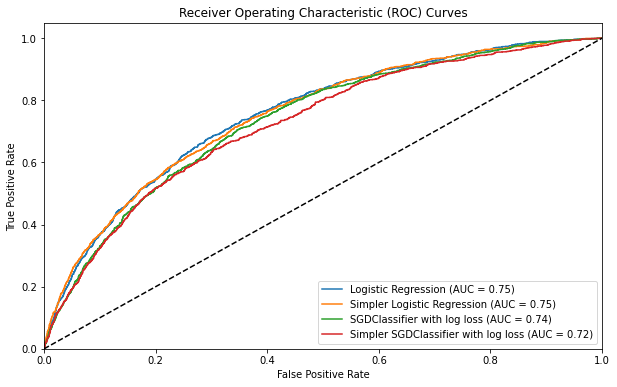

In [19]:
# Calculate the ROC curves for all models
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logistic_regression.predict_proba(X_test)[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_logreg_simpler, tpr_logreg_simpler, _ = roc_curve(y_test_simpler, logistic_regression_simpler.predict_proba(X_test_simpler)[:, 1])
roc_auc_logreg_simpler = auc(fpr_logreg_simpler, tpr_logreg_simpler)

fpr_sgd_log, tpr_sgd_log, _ = roc_curve(y_test, sgd_log.predict_proba(X_test)[:, 1])
roc_auc_sgd_log = auc(fpr_sgd_log, tpr_sgd_log)

fpr_sgd_log_simpler, tpr_sgd_log_simpler, _ = roc_curve(y_test_simpler, sgd_log_simpler.predict_proba(X_test_simpler)[:, 1])
roc_auc_sgd_log_simpler = auc(fpr_sgd_log_simpler, tpr_sgd_log_simpler)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_logreg_simpler, tpr_logreg_simpler, label=f'Simpler Logistic Regression (AUC = {roc_auc_logreg_simpler:.2f})')
plt.plot(fpr_sgd_log, tpr_sgd_log, label=f'SGDClassifier with log loss (AUC = {roc_auc_sgd_log:.2f})')
plt.plot(fpr_sgd_log_simpler, tpr_sgd_log_simpler, label=f'Simpler SGDClassifier with log loss (AUC = {roc_auc_sgd_log_simpler:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

Let's try hyperparameter tuning to see whether there's a preprocessing/training combination of parameters that increases the AUC metric.

In [37]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42)),
])

param_grid = [
    {
        'preprocessing__range_based__imputer__strategy': ['median', 'mean', 'most_frequent'],
        'preprocessing__float_transform__imputer__strategy': ['median', 'mean', 'most_frequent'],
        'log_reg__C': [0.1, 1, 10],
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
]

# Use 'roc_auc' as the scoring metric
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='roc_auc', refit=True)
grid_search.fit(train, train_labels)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['x33',
                                                                          'x77',
                                                                          'x3',
                                                                          'x60',
                                                                          'x65']),
                                                                        ('range_based',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('custom_discretizer',
                                                                                          FunctionTransforme...
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid=[{'log_reg__C': [0.1, 1, 10],
                          'log_reg__penalty': ['l1', 'l2'],
                          'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                              'sag', 'saga'],
                          'preprocessing__float_transform__imputer__strategy': ['median',
                                                                                'mean',
                                                                                'most_frequent'],
                          'preprocessing__range_based__imputer__strategy': ['median',
                                                                            'mean',
                                                                            'most_frequent']}],
             scoring='roc_auc')

In [38]:
grid_search.best_params_

{'log_reg__C': 1,
 'log_reg__penalty': 'l1',
 'log_reg__solver': 'saga',
 'preprocessing__float_transform__imputer__strategy': 'most_frequent',
 'preprocessing__range_based__imputer__strategy': 'mean'}

In [39]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log_reg__C,param_log_reg__penalty,param_log_reg__solver,param_preprocessing__float_transform__imputer__strategy,param_preprocessing__range_based__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
133,11.048126,1.361842,0.053183,0.001527,1,l1,saga,most_frequent,mean,"{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'l...",0.721299,0.755594,0.724034,0.733642,0.015562,1
60,0.566791,0.066664,0.072784,0.003745,0.1,l2,lbfgs,most_frequent,median,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l2', ...",0.720814,0.755694,0.724269,0.733592,0.015692,2
79,3.114878,0.260038,0.060701,0.008325,0.1,l2,sag,most_frequent,mean,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l2', ...",0.721466,0.755325,0.723974,0.733588,0.015404,3
78,3.163240,0.319609,0.061889,0.013163,0.1,l2,sag,most_frequent,median,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l2', ...",0.720815,0.755666,0.724262,0.733581,0.015680,4
132,10.599569,1.501656,0.059168,0.010429,1,l1,saga,most_frequent,median,"{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'l...",0.720716,0.755769,0.724252,0.733579,0.015757,5


<Axes: >

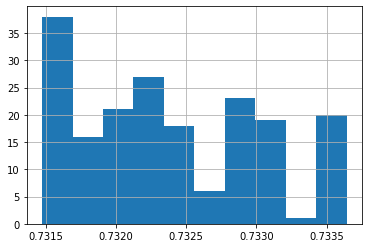

In [42]:
cv_res['mean_test_score'].hist()

The parameter search did not make a meaningful difference in the AUC score. So, we will stick with our original model with the sophisticated pipeline.

Next, we will train a decision tree, random forest, gradient boosting, support vector machine and neural network models.

In [21]:
# Define the models
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Support Vector Machine", SVC(probability=True, random_state=42)),
    ("Neural Network", MLPClassifier(max_iter=1000, random_state=42)),
]

Train the models using cross-validation and compare their AUC scores.

In [22]:
for name, model in models:
    if name == "Support Vector Machine":
        decision_function_scores = cross_val_predict(model, X_train, y_train, cv=5, method='decision_function')
        auc_score = roc_auc_score(y_train, decision_function_scores)
        print(f"{name} - AUC: {auc_score:.4f}")
    else: 
        cv_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"{name} - mean AUC: {cv_auc_scores.mean():.4f}, std: {cv_auc_scores.std():.4f}")

Decision Tree - mean AUC: 0.5653, std: 0.0057
Random Forest - mean AUC: 0.7165, std: 0.0069
Gradient Boosting - mean AUC: 0.7818, std: 0.0089
Support Vector Machine - AUC: 0.7200
Neural Network - mean AUC: 0.6824, std: 0.0048


It looks like the Gradient Boosting model performed the best. Let's try another round of hyperparameter tuning, focusing on only the modeling parameters this time, for Gradient Boosting.

In [27]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("grad_boost", GradientBoostingClassifier(random_state=42)),
])

param_grid = [
    {
        'grad_boost__n_estimators': [5,50,250,500],
        'grad_boost__max_depth':[1,3,5,7,9],
        'grad_boost__learning_rate':[0.01,0.1,1,10,100]
    },
]

# Use 'roc_auc' as the scoring metric
grid_search_gb = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='roc_auc', refit=True)
grid_search_gb.fit(train, train_labels)

KeyboardInterrupt: ignored

I ran out of time and was not able to tune these hyperparameters. Gradient boosting classifiers take a long time to train. Let's retrain the gradient boosting model.

In [31]:
# Create the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform 5-fold cross-validation and get the AUC scores
cv_auc_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='roc_auc')

# Calculate the mean AUC and standard deviation
mean_auc = cv_auc_scores.mean()
std_auc = cv_auc_scores.std()

# Print the results
print(f"Gradient Boosting - mean AUC: {mean_auc:.4f}, std: {std_auc:.4f}")

# Train the Gradient Boosting model on the entire training set
gb_model.fit(X_train, y_train)

Gradient Boosting - mean AUC: 0.7816, std: 0.0080


GradientBoostingClassifier(random_state=42)

Save the models for use in other notebooks.

In [32]:
joblib.dump(logistic_regression, 'logistic_regression_model.pkl')
joblib.dump(gb_model, 'gb_model.pkl')
files.download('logistic_regression_model.pkl')
files.download('gb_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>